<a href="https://colab.research.google.com/github/vaishnavivyasam/Vaishnavi_INFO5731_Fall2021/blob/main/In_class_exercise_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The seventh in-class-exercise (40 points in total, 10/20/2021)**

Question description: Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks:

## (1) (15 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [1]:
import nltk; 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
pip install spacy

In [47]:
pip install pyLDAvis==2.1.2 # instally pyLDvis version 2.1.2

     |████████████████████████████████| 1.6 MB 5.2 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97738 sha256=b308df0a5af3e26ec30169ada56274f86d49e7feb5d9464aee3d25c1ae18ba71
  Stored in directory: /root/.cache/pip/wheels/3b/fb/41/e32e5312da9f440d34c4eff0d2207b46dc9332a7b931ef1e89
Successfully built pyLDAvis


In [48]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
#import pyLDAvis.gensim_models as gensimvis

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [5]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [8]:
import pandas as pd
df = pd.read_csv("citeseerX.csv")
df.head()

,Unnamed: 0,Title,Abstract
0,0,The Determinants of Credit Spread Changes.,"""... ABSTRACT Using dealer's quotes and trans..."
1,1,Smart Sensing Technology: Opportunities and Ch...,"""... ABSTRACT: “Smart ” sensors with embedded ..."
2,2,Structural health monitoring using smart sensors,"""... of excellence in research and education t..."
3,3,Whom You Know Matters: Venture Capital Network...,"""... Abstract Many financial markets are char..."
4,4,A Survey on Wearable Sensor-Based Systems for ...,"""... Abstract—The design and development of we..."


In [49]:
# Converting to list
data = df.Abstract.values.tolist()

# Removing new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

pprint(data[:1])

['"... ABSTRACT Using dealer\'s quotes and transactions prices on straight '
 'industrial bonds, we investigate the determinants of credit spread changes. '
 'Variables that should in theory determine credit spread changes have rather '
 'limited explanatory power. Further, the residuals from this regression are '
 '..."']


In [10]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['abstract', 'using', 'dealer', 'quotes', 'and', 'transactions', 'prices', 'on', 'straight', 'industrial', 'bonds', 'we', 'investigate', 'the', 'determinants', 'of', 'credit', 'spread', 'changes', 'variables', 'that', 'should', 'in', 'theory', 'determine', 'credit', 'spread', 'changes', 'have', 'rather', 'limited', 'explanatory', 'power', 'further', 'the', 'residuals', 'from', 'this', 'regression', 'are']]


In [11]:
# Building the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['abstract', 'using', 'dealer_quotes', 'and', 'transactions', 'prices', 'on', 'straight_industrial_bonds', 'we', 'investigate', 'the', 'determinants', 'of', 'credit_spread_changes', 'variables', 'that', 'should', 'in', 'theory_determine', 'credit_spread_changes', 'have', 'rather', 'limited_explanatory', 'power', 'further', 'the', 'residuals', 'from', 'this', 'regression', 'are']


In [12]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [13]:
# Removing Stop Words
data_words_nostops = remove_stopwords(data_words)

# Forming Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initializing spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

# lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['use', 'transaction', 'price', 'bond', 'investigate', 'determinant', 'credit_spread', 'change', 'variable', 'credit_spread', 'change', 'rather', 'limited_explanatory', 'power', 'residual', 'regression']]


In [14]:
# Creating Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Creating Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1])

[[(0, 1), (1, 2), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]]


In [15]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('bond', 1),
  ('change', 2),
  ('credit_spread', 2),
  ('determinant', 1),
  ('investigate', 1),
  ('limited_explanatory', 1),
  ('power', 1),
  ('price', 1),
  ('rather', 1),
  ('regression', 1),
  ('residual', 1),
  ('transaction', 1),
  ('use', 1),
  ('variable', 1)]]

In [16]:
# Building LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [17]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.238*"information" + 0.220*"health" + 0.118*"potential" + 0.116*"system" + '
  '0.107*"technology" + 0.009*"focus" + 0.008*"build" + 0.007*"trust" + '
  '0.007*"productivity" + 0.006*"offer"'),
 (1,
  '0.081*"relationship" + 0.080*"market" + 0.043*"consequence" + '
  '0.043*"establish" + 0.041*"network" + 0.040*"financial" + 0.040*"abstract" '
  '+ 0.040*"performance" + 0.040*"organizational" + 0.040*"many"'),
 (2,
  '0.094*"management" + 0.093*"delivery" + 0.093*"make" + 0.091*"aspect" + '
  '0.091*"interest" + 0.091*"refer" + 0.091*"safe" + 0.086*"due" + '
  '0.018*"model" + 0.014*"program"'),
 (3,
  '0.071*"increasingly" + 0.049*"due" + 0.049*"health" + 0.048*"factor" + '
  '0.048*"provide" + 0.048*"smartphone" + 0.048*"small" + 0.048*"ubiquitous" + '
  '0.048*"widespread" + 0.048*"variety"'),
 (4,
  '0.066*"propose" + 0.046*"effective" + 0.046*"review" + 0.046*"still" + '
  '0.025*"policy" + 0.023*"reform" + 0.019*"finding" + 0.019*"receive" + '
  '0.019*"condition" + 0.01

In [18]:
# Computing Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -3.595573677721291

Coherence Score:  0.666745089593166


In [19]:
# Visualizing the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11    -0.209822 -0.023530       1        1  19.617519
19    -0.142202  0.199231       2        1  12.122644
17    -0.219204 -0.222664       3        1  10.045707
6     -0.122930  0.226011       4        1   9.941484
3     -0.146410  0.111756       5        1   9.466079
12    -0.143882  0.178089       6        1   8.637791
8     -0.242539 -0.249498       7        1   8.327247
13    -0.200209 -0.025815       8        1   8.264815
1     -0.055772  0.165068       9        1   5.408120
2      0.036074  0.122635      10        1   2.237121
0     -0.136300 -0.198979      11        1   1.655721
15     0.161492 -0.043665      12        1   0.944954
14     0.137793  0.055588      13        1   0.925106
16     0.114357  0.035305      14        1   0.802093
9      0.082836 -0.173672      15        1   0.680712
4      0.207721 -0.011225      16        1   0.277135
7      0.211375 -0.053296      17        1   0.238114
18     0.221047 -0.030216      18        1   0.179097
5      0.224072 -0.030947      19        1   0.157678
10     0.222504 -0.030176      20        1   0.070864, topic_info=           Term        Freq       Total Category  logprob  loglift
30       system  643.000000  643.000000  Default  30.0000  30.0000
75       health  447.000000  447.000000  Default  29.0000  29.0000
26    potential  241.000000  241.000000  Default  28.0000  28.0000
95          due  345.000000  345.000000  Default  27.0000  27.0000
126  technology  302.000000  302.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
223    decrease    0.019403   65.824777  Topic20  -6.6851  -0.8772
224   designing    0.019403   65.824777  Topic20  -6.6851  -0.8772
225   detection    0.019403   65.824777  Topic20  -6.6851  -0.8772
226  distribute    0.019403   66.251906  Topic20  -6.6851  -0.8836
202   composite    0.019403   86.814582  Topic20  -6.6851  -1.1539

[799 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
544      18  0.659962        able
50        8  0.578745    abstract
50        9  0.420905    abstract
545      18  0.659962  accelerate
90        5  0.993451  accessible
...     ...       ...         ...
353      10  0.816889       world
471      15  0.704817       write
582      20  0.612002       wssns
89        3  0.988250        year
108       5  0.993451         yet

[527 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 20, 18, 7, 4, 13, 9, 14, 2, 3, 1, 16, 15, 17, 10, 5, 8, 19, 6, 11])

In [20]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

--2021-10-22 20:12:39--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  13.5MB/s    in 1.1s    

2021-10-22 20:12:41 (13.5 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]



In [21]:
!unzip mallet-2.0.8.zip

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classify  
  inflating: mallet-2.0.8/bin/text2vectors  
  inflating: mallet-2.0.8/bin/vectors2classify  
  inflating: mallet-2.0.8/bin/vectors2info  
  inflating: mallet-2.0.8/bin/vectors2topics  
  inflating: mallet-2.0.8/bin/vectors2vectors  
  inflating: mallet-2.0.8/build.xml  
   creating: mallet-2.0.8/class/
   creating: mallet-2.0.8/class/cc/
   creating: mallet-2.0.8/class/cc/mallet/
   creating: mallet-2.0.8/class/cc/mallet/classify/
  inflating: mallet-2.0.8/class/cc/mallet/classify/AdaBoost.class  
  in

In [22]:
mallet_path = "/content/mallet-2.0.8/bin/mallet"

In [23]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [24]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(5,
  [('increase', 0.07627118644067797),
   ('year', 0.07274011299435028),
   ('attention', 0.07203389830508475),
   ('motivate', 0.0713276836158192),
   ('community', 0.07062146892655367),
   ('healthcare', 0.07062146892655367),
   ('biose', 0.07062146892655367),
   ('lot', 0.07062146892655367),
   ('garner', 0.07062146892655367),
   ('miniature', 0.07062146892655367)]),
 (0,
  [('health', 0.5203094777562862),
   ('technology', 0.2804642166344294),
   ('program', 0.019342359767891684),
   ('evaluation', 0.019342359767891684),
   ('policy', 0.017408123791102514),
   ('issue', 0.013539651837524178),
   ('public', 0.009671179883945842),
   ('methodology', 0.009671179883945842),
   ('current', 0.009671179883945842),
   ('heal', 0.007736943907156673)]),
 (4,
  [('system', 0.5687022900763359),
   ('save', 0.015267175572519083),
   ('world', 0.015267175572519083),
   ('model', 0.015267175572519083),
   ('focus', 0.011450381679389313),
   ('observational', 0.011450381679389313),
   ('financ

In [25]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [26]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

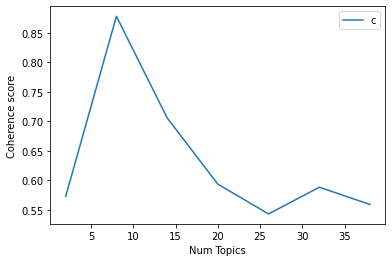

In [27]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [28]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5724
Num Topics = 8  has Coherence Value of 0.8782
Num Topics = 14  has Coherence Value of 0.7058
Num Topics = 20  has Coherence Value of 0.5933
Num Topics = 26  has Coherence Value of 0.5428
Num Topics = 32  has Coherence Value of 0.5881
Num Topics = 38  has Coherence Value of 0.5589


In [29]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.305*"research" + 0.290*"health" + 0.286*"due" + 0.011*"observational" + '
  '0.006*"strength" + 0.006*"assessment" + 0.006*"biomedical" + '
  '0.006*"epidemiology" + 0.006*"weakness" + 0.006*"strobe"'),
 (1,
  '0.242*"monitoring" + 0.225*"cost" + 0.220*"recent" + 0.199*"advance" + '
  '0.010*"save" + 0.007*"focus" + 0.006*"finance" + 0.005*"baby" + '
  '0.005*"blend" + 0.005*"boomer"'),
 (2,
  '0.164*"health" + 0.119*"care" + 0.103*"information" + 0.072*"technology" + '
  '0.055*"application" + 0.052*"increasingly" + 0.050*"make" + '
  '0.050*"management" + 0.048*"delivery" + 0.047*"interest"'),
 (3,
  '0.317*"technology" + 0.309*"due" + 0.126*"area" + 0.111*"research" + '
  '0.089*"sensor" + 0.003*"clinic" + 0.003*"record" + 0.003*"smart" + '
  '0.003*"teacher" + 0.002*"recognize"'),
 (4,
  '0.067*"home" + 0.066*"include" + 0.066*"people" + 0.063*"study" + '
  '0.060*"support" + 0.059*"result" + 0.059*"loss" + 0.058*"evolution" + '
  '0.058*"nowadays" + 0.058*"efficient"'),


In [30]:

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,18.0,0.2405,"system, civil, change, smart, credit_spread, e...","""... ABSTRACT Using dealer's quotes and transa..."
1,1,9.0,0.1103,"communication, note, change, report, control, ...","""... ABSTRACT: “Smart ” sensors with embedded ..."
2,2,10.0,0.2802,"carry, extended, floor, height, clear, complet...","""... of excellence in research and education t..."
3,3,13.0,0.3372,"relationship, market, establish, strong, conse...","""... Abstract Many financial markets are chara..."
4,4,11.0,0.2357,"increase, year, attention, motivate, lot, heal...","""... Abstract—The design and development of we..."
5,5,17.0,0.2541,"propose, factor, provide, camera, variety, sma...","""... Background: The SenseCam, a small camera ..."
6,6,15.0,0.1214,"maintain, embed, control, networked, microproc...","""... “Smart ” sensors with embedded microproce..."
7,7,4.0,0.2662,"home, include, people, study, support, result,...","""... Health Smart Homes are nowadays a very ex..."
8,8,19.0,0.2101,"project, structural, present, develop, high, a...","""... This paper presents recent advances in th..."
9,9,18.0,0.1328,"system, civil, change, smart, credit_spread, e...","""... Can organic and resource-conserving agric..."


In [31]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.2413,"research, health, due, observational, strength...","""... A B S T R A C T Much biomedical research ..."
1,1.0,0.3000,"monitoring, cost, recent, advance, save, focus...","""... Recent research on wealth and household f..."
2,2.0,0.2617,"health, care, information, technology, applica...","""... Health informatics is increasingly of int..."
3,3.0,0.0758,"technology, due, area, research, sensor, clini...","""... The research described in this paper is m..."
4,4.0,0.2693,"home, include, people, study, support, result,...","""... Health Smart Homes are nowadays a very ex..."


In [32]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,18.0,"system, civil, change, smart, credit_spread, e...",4.0,0.004
1.0,9.0,"communication, note, change, report, control, ...",4.0,0.004
2.0,10.0,"carry, extended, floor, height, clear, complet...",38.0,0.038
3.0,13.0,"relationship, market, establish, strong, conse...",2.0,0.002
4.0,11.0,"increase, year, attention, motivate, lot, heal...",100.0,0.100
...,...,...,...,...
995.0,4.0,"home, include, people, study, support, result,...",NaN,NaN
996.0,19.0,"project, structural, present, develop, high, a...",NaN,NaN
997.0,8.0,"structure, advanced, panel, material, tendon, ...",NaN,NaN
998.0,5.0,"researcher, lead, early, problem, intelligent,...",NaN,NaN


## (2) (15 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [1]:
#importing modules
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [5]:
import pandas as pd
df = pd.read_csv("citeseerX.csv")
df.head()

,Unnamed: 0,Title,Abstract
0,0,The Determinants of Credit Spread Changes.,"""... ABSTRACT Using dealer's quotes and trans..."
1,1,Smart Sensing Technology: Opportunities and Ch...,"""... ABSTRACT: “Smart ” sensors with embedded ..."
2,2,Structural health monitoring using smart sensors,"""... of excellence in research and education t..."
3,3,Whom You Know Matters: Venture Capital Network...,"""... Abstract Many financial markets are char..."
4,4,A Survey on Wearable Sensor-Based Systems for ...,"""... Abstract—The design and development of we..."


In [52]:
def load_data(path,file_name):
    """
    Input  : path and file_name
    Purpose: loading text file
    Output : list of paragraphs/documents and
             title(initial 100 words considred as title of document)
    """
    Review_list = []
    titles=[]
    with open( os.path.join(path, file_name) ,"r") as fin:
        for line in fin.readlines():
            text = line.strip()
            Review_list.append(text)
    print("Total Number of Reviews:",len(Review_list))
    titles.append( text[0:min(len(text),100)] )
    return Review_list,titles

In [53]:
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    print(df.Abstract)
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        i=str(i)
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # removing stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

In [37]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix
dictionary,doc_term_matrix=prepare_corpus(texts)

In [44]:
#LSA model using Gensim
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [43]:
#Determining the number of topics
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generating LSA model
        model = LsiModel(doc_term_matrix, num_topics=10, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values
model_list,coherence_values=compute_coherence_values(dictionary,doc_term_matrix,texts,12,2,1)

In [42]:
#ploting coherence score values graphically

def plot_graph(doc_clean,start,stop,step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start,stop,step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

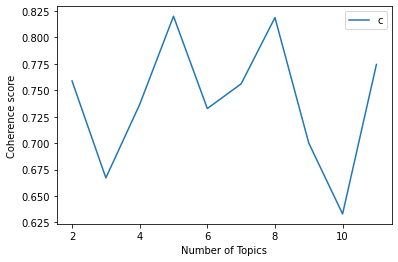

In [41]:
start,stop,step=2,12,1
plot_graph(texts,start,stop,step)

In [62]:
# LSA Model
number_of_topics=7
words=10
Review_list,titles=load_data("","citeseerX.csv")
texts=preprocess_data(Review_list)
model=create_gensim_lsa_model(texts,number_of_topics,words)

Total Number of Reviews: 1001
0      "...  ABSTRACT Using dealer's quotes and trans...
1      "... ABSTRACT: “Smart ” sensors with embedded ...
2      "... of excellence in research and education t...
3      "...  Abstract Many financial markets are char...
4      "... Abstract—The design and development of we...
                             ...                        
995    "... Health Smart Homes are nowadays a very ex...
996    "... This paper presents recent advances in th...
997    "... SUMMARY:  Many advanced composite materia...
998    "... Abstract. A main goal for the researchers...
999    "... Health informatics is increasingly of int...
Name: Abstract, Length: 1000, dtype: object
[(0, '0.357*"smart" + 0.341*"health" + 0.284*"structur" + 0.275*"system" + 0.260*"monitor" + 0.247*"technolog" + 0.224*"research" + 0.197*"use" + 0.173*"sensor" + 0.131*"potenti"'), (1, '-0.289*"health" + -0.259*"structur" + 0.191*"system" + 0.156*"network" + 0.155*"control" + 0.155*"wireless" + 0.

## (3) (10 points) Compare the results generated by the two topic modeling algorithms, which one is better? You should explain the reasons in details.

In [ ]:
For the LDA model,
Coherence Score:  0.666745089593166
And for the LSA model, we can get know the coherence value the graph which is approximately 0.73.as_integer_ratio

From the above coherence values, we can find that LDA model performed better when compared to the LSA model. Also, LDA model can provide
the optimal model. LDA model produces a simpler martix while LSA model produces a model which is of high density. LDA model is easier to implement while
LSA model is quite complex to implement.

Hence LDA model is better When compared to the LSA model.
